**Phase 1: Setup & Data Download**

In [ ]:
# Step 1: Install Kagglehub
!pip install -q kagglehub

# Step 2: Download the dataset
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("romainpessia/artificial-lunar-rocky-landscape-dataset")

print("✅ Dataset downloaded to:", path)

# Step 3: Check the folder structure so we know where images are
# The dataset usually has 'images/render' (Input) and 'images/clean' (Target Mask)
print("Folder contents:", os.listdir(path))
if 'images' in os.listdir(path):
    print("Sub-folder contents:", os.listdir(os.path.join(path, 'images')))

 62%|██████▏   | 3.09G/5.02G [00:43<00:24, 84.0MB/s]

**Phase 2:** Data Processing (The "Pro" Logic)
This is the most critical part. The dataset masks are RGB (Colored), but U-Net expects a Binary Map (0 or 1).

**Original Mask**: Blue = Big Rocks, Green = Small Rocks, Red = Sky.

**Our Logic:** We want to detect Hazards. So we will convert Blue & Green (Rocks) into White (1) and everything else to Black (0).

Loaded 2000 images and masks.
Processing data... this may take a minute...
Data Ready! (2000, 128, 128, 1) (2000, 128, 128, 1)


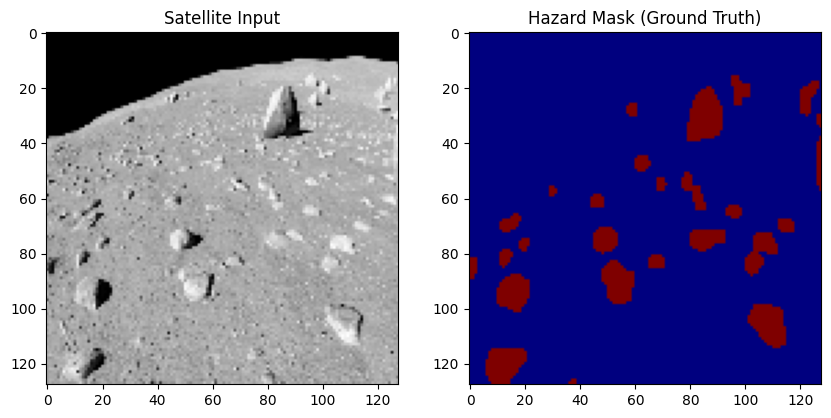

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import glob

# Configuration
IMG_SIZE = 128  # Resize to 128x128 for speed (Use 256 for better quality if you have time)
BATCH_SIZE = 16

# Define Paths
# 'render' contains the fake moon surface images
# 'clean' contains the ground truth masks (cleaner than 'ground' folder)
image_dir = os.path.join(path, 'images', 'render')
mask_dir = os.path.join(path, 'images', 'clean')

# Get file lists (sort them to ensure alignment!)
image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.png')))

# Limit data for the mini-project to save RAM (Optional: remove [:1000] to use all data)
image_paths = image_paths[:2000]
mask_paths = mask_paths[:2000]

print(f"Loaded {len(image_paths)} images and masks.")

def load_and_process_data(img_paths, mask_paths):
    X = []
    Y = []

    for img_p, mask_p in zip(img_paths, mask_paths):
        # 1. Load Image (Grayscale is enough for moon)
        img = cv2.imread(img_p, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        # Normalize to 0-1
        img = img / 255.0
        img = np.expand_dims(img, axis=-1) # Shape: (128, 128, 1)

        # 2. Load Mask
        # We load as Color (RGB) because classes are color-coded
        mask = cv2.imread(mask_p, cv2.IMREAD_COLOR)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        # 3. Create Binary Hazard Map
        # Blue Channel (Channel 0 in OpenCV BGR) = Large Rocks
        # Green Channel (Channel 1 in OpenCV BGR) = Small Rocks
        # Logic: If pixel has Blue OR Green > 50, it is a Hazard (1)
        hazard_mask = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

        # Detect rocks (Blue or Green channel intensity)
        # Note: OpenCV is BGR. Blue is index 0, Green is index 1.
        rocks = np.maximum(mask[:,:,0], mask[:,:,1])

        hazard_mask[rocks > 50] = 1.0 # Set hazard pixels to 1

        X.append(img)
        Y.append(hazard_mask)

    return np.array(X), np.array(Y)

# Load the data into RAM
print("Processing data... this may take a minute...")
X, Y = load_and_process_data(image_paths, mask_paths)
print("Data Ready!", X.shape, Y.shape)

# VISUALIZATION CHECK
# Always check your data before training!
idx = 10
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[idx].squeeze(), cmap='gray')
plt.title("Satellite Input")
plt.subplot(1, 2, 2)
plt.imshow(Y[idx].squeeze(), cmap='jet')
plt.title("Hazard Mask (Ground Truth)")
plt.show()

**Phase 3**: Build the U-Net Model
This is the standard architecture for segmentation.

In [3]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    # Output (Sigmoid for binary classification per pixel)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return Model(inputs=[inputs], outputs=[outputs])

model = build_unet((IMG_SIZE, IMG_SIZE, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     32,832 │ conv2d_7[0][0]  

 Total params: 481,745 (1.84 MB)

 Trainable params: 481,745 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

**Phase 4**: Training

In [4]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Train
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=15,  # 15 epochs is usually enough for this dataset
    verbose=1
)

# Save the model
model.save('lunar_hazard_model.h5')
print("Model Saved!")

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9484 - loss: 0.3090 - val_accuracy: 0.9600 - val_loss: 0.1637
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9531 - loss: 0.1742 - val_accuracy: 0.9600 - val_loss: 0.1433
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9516 - loss: 0.1438 - val_accuracy: 0.9614 - val_loss: 0.1095
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9517 - loss: 0.1365 - val_accuracy: 0.9650 - val_loss: 0.0965
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9584 - loss: 0.1180 - val_accuracy: 0.9676 - val_loss: 0.0890
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9594 - loss: 0.1124 - val_accuracy: 0.9638 - val_loss: 0.1174
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9602 - loss: 0.1113 - val_accuracy: 0.9678 - val_loss: 0.0930
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9652 - loss: 0.0980 - val_accu

Model Saved!


**Phase 5**: Test on New Image (The Demo)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


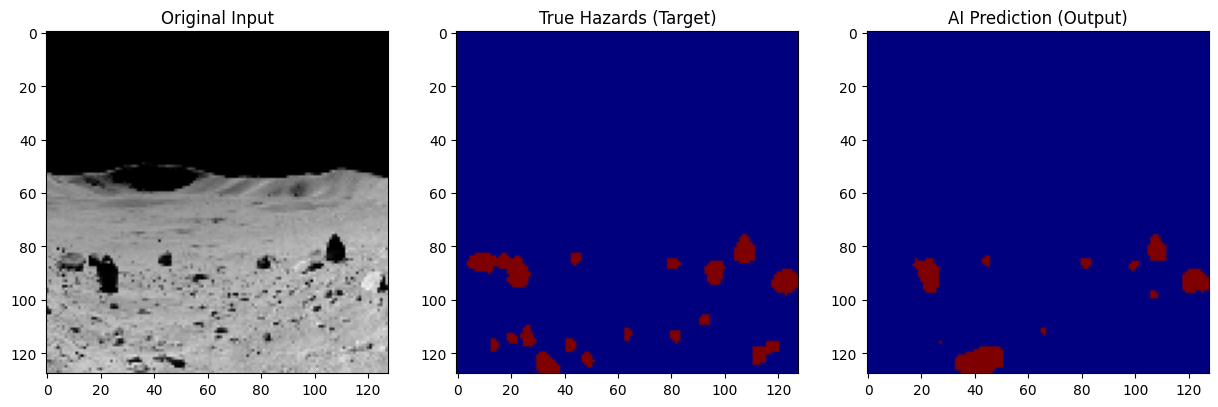

In [5]:
# Predict on a validation image
idx = 5 # Change this number to test different images
test_img = X_val[idx]
ground_truth = Y_val[idx]

# Predict
pred_mask = model.predict(np.expand_dims(test_img, axis=0))[0]

# Threshold (convert probability to 0 or 1)
pred_mask_binary = (pred_mask > 0.5).astype(np.float32)

# Plot Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Input")
plt.imshow(test_img.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("True Hazards (Target)")
plt.imshow(ground_truth.squeeze(), cmap='jet')

plt.subplot(1, 3, 3)
plt.title("AI Prediction (Output)")
plt.imshow(pred_mask_binary.squeeze(), cmap='jet')

plt.show()

The "Auto-Pilot" Logic (Automatic Landing Site Selection)

In [18]:
def process_mission(image, sensitivity):
    if image is None: return None, "Waiting for satellite feed..."

    # 1. KEEP ORIGINAL SIZE
    # We save the original height/width to restore quality later
    orig_h, orig_w = image.shape[:2]

    # 2. PREPARE FOR AI (Downscale to 128x128)
    img_resized = cv2.resize(image, (128, 128))
    img_norm = img_resized / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    if len(img_input.shape) == 3: img_input = np.expand_dims(img_input, axis=-1)

    # 3. PREDICT
    pred_mask = model.predict(img_input)[0]
    binary_mask = (pred_mask > sensitivity).astype(np.uint8)

    # 4. CALCULATE SAFE ZONE (On the small map for speed)
    safe_area = ((1 - binary_mask) * 255).astype(np.uint8)
    buffer = 5
    safe_area[:buffer, :] = 0; safe_area[-buffer:, :] = 0
    safe_area[:, :buffer] = 0; safe_area[:, -buffer:] = 0

    dist = cv2.distanceTransform(safe_area.squeeze(), cv2.DIST_L2, 5)
    _, max_val, _, max_loc = cv2.minMaxLoc(dist)

    # 5. UPSCALE RESULTS TO ORIGINAL QUALITY
    # Resize the 128x128 mask back up to the ORIGINAL size (e.g., 1000x1000)
    # Use INTER_LINEAR to make the red blocks look smoother/rounder
    mask_high_res = cv2.resize(binary_mask, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)

    # Scale the coordinates from 128-space to Original-space
    scale_x = orig_w / 128.0
    scale_y = orig_h / 128.0

    center_high_res = (int(max_loc[0] * scale_x), int(max_loc[1] * scale_y))
    radius_high_res = max_val * max(scale_x, scale_y)

    # 6. VISUALIZATION (Draw on the ORIGINAL image)
    # Convert original to RGB if needed
    if len(image.shape) == 2: display_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else: display_img = image.copy() # Already RGB

    # Draw Red Hazards (Transparent)
    hazard_layer = display_img.copy()
    # Logic: Where the mask is > 0 (hazard), paint it Red
    hazard_layer[mask_high_res > 0] = [255, 0, 0]

    # Blend: 70% Original Image + 30% Red Tint
    display_img = cv2.addWeighted(display_img, 0.7, hazard_layer, 0.3, 0)

    # Draw HUD (Your v3 function handles dynamic sizing automatically!)
    final_output = draw_hud_v3(display_img, center_high_res, radius_high_res, 0.99)

    status = f"✅ TARGET ACQUIRED\n📍 Sector: {center_high_res}\n🛡️ Safe Radius: {radius_high_res:.1f} pixels"
    if radius_high_res < 20: status = "⚠️ ABORT: NO SAFE ZONE FOUND"

    return final_output, status

"Mission Control" Dashboard (Interactive UI)

In [19]:
!pip install -q gradio

import gradio as gr

def mission_control(image, sensitivity):
    # 1. Preprocess
    img_resized = cv2.resize(image, (128, 128))
    img_norm = img_resized / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    img_input = np.expand_dims(img_input, axis=-1)

    # 2. Predict
    prediction = model.predict(img_input)[0]

    # 3. Apply Sensitivity Threshold (Dynamic Adjustment!)
    # Lower sensitivity = More cautious (detects small bumps as hazards)
    binary_mask = (prediction > sensitivity).astype(np.uint8)

    # 4. Find Safe Zone (Reusing previous logic)
    safe_area = ((1 - binary_mask) * 255).astype(np.uint8)
    dist = cv2.distanceTransform(safe_area.squeeze(), cv2.DIST_L2, 5)
    _, r, _, center = cv2.minMaxLoc(dist)

    # 5. Draw Visuals
    result_img = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)

    # Red overlay for hazards
    result_img[binary_mask.squeeze() == 1] = [255, 0, 0]

    # Green Target
    if r > 0:
        cv2.circle(result_img, center, int(r), (0, 255, 0), 2)

    return result_img, f"Safe Radius: {r:.2f} pixels"

# Create the Interface
iface = gr.Interface(
    fn=mission_control,
    inputs=[
        gr.Image(image_mode='L'), # Upload grayscale image
        gr.Slider(0.1, 0.9, value=0.5, label="Hazard Sensitivity Threshold")
    ],
    outputs=[
        gr.Image(label="Lander Vision System"),
        "text"
    ],
    title="🚀 LunarSafe: Autonomous Landing System",
    description="Upload a moon surface image. The AI will detect hazards (Red) and calculate the optimal landing target (Green)."
)

# Launch (Share=True gives you a public link to show on your phone!)
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://243e262513b053544c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
